<a href="https://colab.research.google.com/github/melissa-aguiar/tilecal-simulator/blob/main/tile_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas e carregando arquivos


**Passo 1:** Importando as bibliotecas do python:

In [37]:
import scipy.io
import random
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from plotly import graph_objects as go
from google.colab import files

**Passo 2:** Importando o google drive para o google colab:

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Passo 3:** Carregando os arquivo de dados:

In [39]:
pulsos_fases = np.loadtxt('/content/drive/MyDrive/pulsos_fases.txt')
pulsos_fases_calda_100n = np.loadtxt('/content/drive/MyDrive/pulsos_fases_calda_100n.txt')
#pulsos_fases_calda_100n =scipy.io.loadmat('/content/drive/MyDrive/pulsos_fases_calda_100n.mat')

#Funções

In [40]:
# Função utilizada para gerar os dados truth para simulações 
#devemos passar para esta função:
#N_amostras= número de amostras à serem geradas
#p_luminos= porcentagem de luminosidade
# retorna os pulsos sorteados e um vetor com a posição de cada pulso

def simdistuni(N_amostras,p_luminos,amplitude_max):
  """ Função utilizada para gerar os dados truth para simulações
  Returns :  
  S_truth :
    An array with the truth data pulses for the simulations.
  posicao : 
    An array with the position for each pulse.
  """

  p_luminos = p_luminos/100; # faço o calculo da porcentagem da luminosidade
  S_truth   = np.zeros(N_amostras)  # crio um vetor de zeros para receber os impulsos de amplitudes sorteadas 
  posicao   = np.random.choice(N_amostras, math.ceil(len(S_truth)*p_luminos)) # sorteio a posição das amostras "OBS:REQUER UM MINIMO DE UM PULSO por conta do rand "
  # existe random.permutation mas so aceita 1 parametro... ai nao entrava o numero de amostras
  amp_aleatoria = amplitude_max*np.random.rand(len(posicao))         # sorteio a amplitude na distribuição uniforme
  
  for i in range (0,len(posicao)):
    S_truth[posicao[i]] = amp_aleatoria[i]

  return S_truth, posicao

In [41]:
def simdistexp(N_amostras,p_luminos,media_exp):
  """
  Função utilizada para gerar os dados truth para simulações
  """

  p_luminos = p_luminos/100; # faço o calculo da porcentagem da luminosidade
  S_truth   = np.zeros(N_amostras)  # crio um vetor de zeros para receber os impulsos de amplitudes sorteadas 
  posicao   = np.random.choice(N_amostras, math.ceil(len(S_truth)*p_luminos)) # sorteio a posição das amostras "OBS:REQUER UM MINIMO DE UM PULSO por conta do rand "
  # existe random.permutation mas so aceita 1 parametro... ai nao entrava o numero de amostras
  amp_aleatoria = np.random.exponential(media_exp,len(posicao))         # sorteio a amplitude na distribuição uniforme

  for i in range (0,len(posicao)):
    S_truth[posicao[i]] = amp_aleatoria[i]
  return S_truth,posicao

In [42]:
def conv_tilecal_pulse(S_truth,desvio,posicao1):
  """
  Função faz a convolução de 2 sinais caso o desvio seja 0 e simula um desvio de fase e convolui caso o desvio seja 1
  """
  matriz_sorteio = pulsos_fases
  N_A = len(matriz_sorteio)
  c = len(matriz_sorteio[0])
  fase_posicao = np.random.randint([1,c],len(posicao1)) #Realizo o sorteio do desvio de fase de -5 a +5 ns
  centro = 0.5 + c/2
  a = (N_A-1)/2
  a = int(a)
  sinal1 = np.zeros(len(S_truth)+N_A-1)  #criando o sinal1 com o comprimento de termos da convolução
  S_truth1 = [np.zeros(a), S_truth, np.zeros(a)] #colocando zeros nas bordas do sinal truth para entrar na "convolução" 
  jj = 1

  for i in range(a, len(S_truth1)-a):
    aux = np.zeros(1,N_A)
    if S_truth1(i)!=0:
      if desvio == 1:   
        for j in range(0,N_A):                                              
           aux[j] = S_truth1[i]*matriz_sorteio[j,fase_posicao[jj]] #algoritmo que convolui sorteando o desvio de fase 
           # caso queira apenas a convolução basta mudar  o vetor matrix para o vetor a ser convoluido 
      else:
        for j in range(0,N_A):
          aux[j] = S_truth1[i]*matriz_sorteio[j,centro]
          # caso o desvio de fase nao seja simulado basta escolher aqui a coluna da matriz sorteio central para convolução neste caso 6
        jj=jj+1
    sinal1[i-a:i+a]=aux+sinal1[i-a:i+a] #caso queira convoluir com apenas uma fase da matrix substituir fase posição pelo numero da coluna da fase
  return sinal1,S_truth1

In [43]:
def conv_longtail_tilecal_pulse(S_truth,desvio,posicao1):
  """
  Função faz a convolução de 2 sinais caso o desvio seja 0 e simula um desvio de fase e convolui caso o desvio seja 1
  """

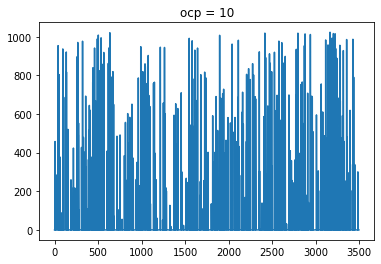

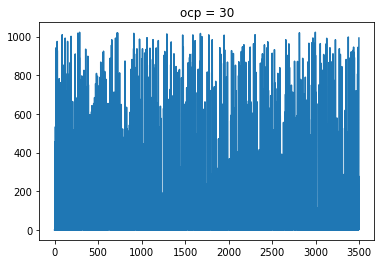

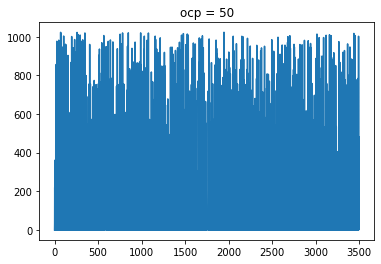

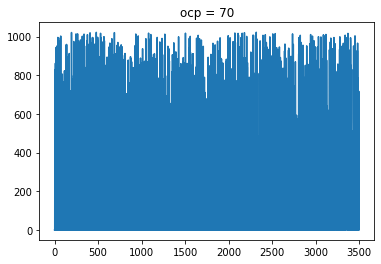

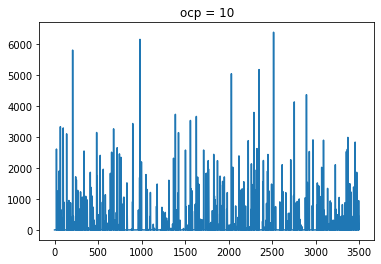

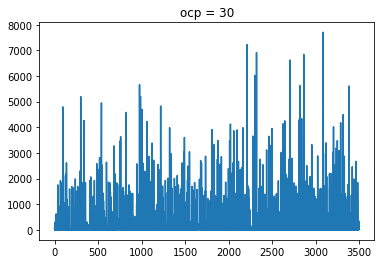

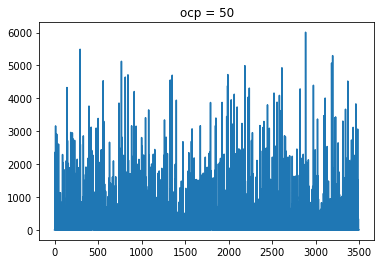

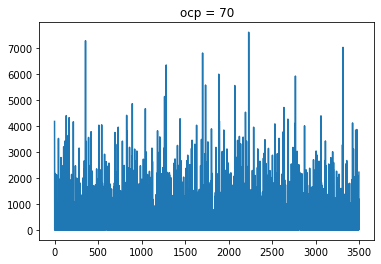

In [45]:
amp    = 1023  #Amplitude máxima
med    = 30    #Média da distribuição exponencial
ocp    = 30    #Ocupação do sinal
rdo    = 1     #Desvio padrão do ruído em ADC counts
fas    = 0     #Desvio de fase do sinal
Ntrn   = 3500  #Quantidade de amostras de treino
Ntst   = 3500  #    || ... teste

for ocp in range (10,90,20):
  eng,pos = simdistuni(Ntrn,ocp,amp)
  snl,eng = conv_tilecal_pulse(eng,0,pos)
  snl     = snl + np.random.randn(rdo,len(snl))
  plt.figure()
  plt.plot(eng[1])
  plt.title('ocp = ' + str(ocp))

for ocp in range (10,90,20):
  eng,pos = simdistexp(Ntst,ocp,amp)
  snl,eng = conv_tilecal_pulse(eng,0,pos)
  snl     = snl + np.random.randn(rdo,len(snl))
  plt.figure()
  plt.plot(eng[1])
  plt.title('ocp = ' + str(ocp))